# Homework 3: Mathias Schmidt

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly
nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has 
applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

In [15]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
from scipy.linalg import solve_banded

In [16]:
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

In [26]:
def nonlinear2d_div(h, x, y, u,  p, eps, forcing, g0, dirichlet=((),())):
                  
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1,j-1),(i-1,j), (i-1,j+1), (i,j-1),
                                                            (i,j),(i,j+1),(i+1,j-1), (i+1,j), (i+1,j+1)]])
            
            grad = numpy.array([ [0    ,-1   ,0    ,0    ,1    ,0   ,0    ,0   ,0  ],
                                 [0    ,0    ,0    ,-1   ,1    ,0   ,0    ,0   ,0  ],
                                 [0    ,0    ,0    ,0    ,-1   ,1   ,0    ,0   ,0  ],
                                 [0    ,0    ,0    ,0    ,-1   ,0   ,0    ,1   ,0  ],
                                 [-1/4 ,-1/4 ,0    ,0    ,0    ,0   ,1/4  ,1/4 ,0  ],
                                 [0    ,-1/4 ,-1/4 ,0    ,0    ,0   ,0    ,1/4 ,1/4],
                                 [-1/4 ,0    ,1/4  ,1/4  ,0    ,1/4 ,0    ,0   ,0  ],
                                 [0    ,0    ,0    ,-1/4 ,0    ,1/4 ,-1/ 4,0   ,1/4]]) / h
                        
             # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]

            grad_x = grad[[0, 4, 3, 5],:] @ ustencil
            grad_y = grad[[6, 1, 7, 2],:] @ ustencil
            grad_normal = grad[0:4,:] #@ ustencil
            
            kappa = (1/2*eps**2+1/2*(grad_x**2+grad_y**2)**2)**((p-2)/2)
            
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad_normal @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad_normal)                
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

 0: anorm 1.000000e+00
 1: anorm 8.659740e-15


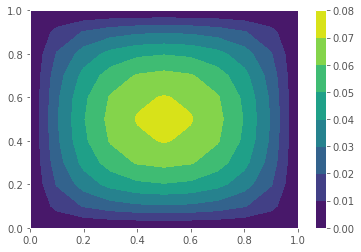

In [79]:
def solve_nonlinear(h, g0, dirichlet,  p , eps, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(50):
        F, J = nonlinear2d_div(h, x, y, u, p, eps, lambda x,y: 0*x+1, g0=g0, dirichlet=((0,-1),(0,-1)) )
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, F)
        u -= deltau.reshape(x.shape)
    return x, y, u, i

x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=True, p=2, eps=2)

pyplot.contourf(x, y, u)
pyplot.colorbar();

Text(0,0.5,'iterations needed')

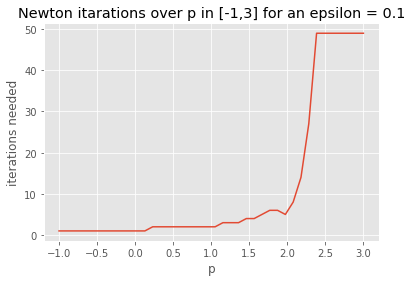

In [98]:
pval = numpy.linspace( -1, 3, 40 ) 
iter = [] 
for p in pval:
    x, y, u, i = solve_nonlinear( 0.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)),verbose=False, p=p, eps=0.1 )
    iter.append(i)
pyplot.plot( pval, iter )
pyplot.title("Newton itarations over p in [-1,3] for an epsilon = 0.1")
pyplot.xlabel( 'p' )
pyplot.ylabel( 'iterations needed' )

Text(0,0.5,'iterations needed')

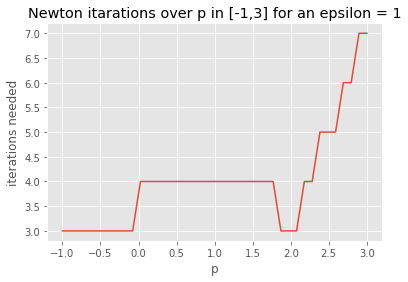

In [105]:
pval = numpy.linspace( -1, 3, 40 ) 
iter = [] 
for p in pval:
    x, y, u, i = solve_nonlinear( 0.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)),verbose=False, p=p, eps=1 )
    iter.append(i)
pyplot.plot( pval, iter )
pyplot.title("Newton itarations over p in [-1,3] for an epsilon = 1")
pyplot.xlabel( 'p' )
pyplot.ylabel( 'iterations needed' )

2. Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

In [145]:
def fsolve_newtonkrylov( h, x, y, p, eps, u0, epsilon=1e-8, rtol=1e-6, maxit=50, verbose=False ):
    u = u0.copy()
    Fu, J = nonlinear2d_div(h, x, y, u, p, eps, lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)) )
    norm0 = numpy.linalg.norm( Fu )
    for i in range( maxit ):
        def Ju_fd(v):
            Fuepsilon, Jueps = nonlinear2d_div(h, x, y, (u+epsilon*v).reshape(x.shape), p, eps,
                                               lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)) )
            return ( Fuepsilon - Fu )/ epsilon
        #Jprecond = splinalg.factorized(J)
        #Jpreop = splinalg.LinearOperator((len(Fu),len(u)), matvec=Jprecond)
        Ju = splinalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
        #du, info = splinalg.gmres(Ju, Fu, atol=1e-06, M=Jpreop)
        du, info = splinalg.gmres(Ju, Fu, atol=1e-06)
        if info != 0:
            print(numpy.linalg.norm(Ju @ du - Fu), norm)
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du
        Fu, _ = nonlinear2d_div(h, x, y, u, p, eps, lambda x,y: 0*x+1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)) )
        norm = numpy.linalg.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'
                  .format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i  

In [155]:
h    = 0.1
eps  = 0.1
p    = 0.6
x,y  = hgrid(h) 
u = 0*x.flatten()
fsolve_newtonkrylov( h, x, y, p, eps, u, rtol=1e-6, verbose=True )

Newton 0 anorm 1.84e-06 rnorm 2.04e-07


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.000314  , 0.00050547, 0.00062239,
        0.00068616, 0.00070648, 0.00068616, 0.00062239, 0.00050547,
        0.000314  , 0.        , 0.        , 0.00050547, 0.00084044,
        0.00105287, 0.00117073, 0.00120851, 0.00117073, 0.00105287,
        0.00084044, 0.00050547, 0.        , 0.        , 0.00062239,
        0.00105287, 0.00133284, 0.00149029, 0.00154107, 0.00149029,
        0.00133284, 0.00105287, 0.00062239, 0.        , 0.        ,
        0.00068616, 0.00117073, 0.00149029, 0.00167147, 0.00173011,
        0.00167147, 0.00149029, 0.00117073, 0.00068616, 0.        ,
        0.        , 0.00070648, 0.00120851, 0.00154107, 0.00173011,
        0.00179138, 0.00173011, 0.00154107, 0.00120851, 0.00070648,
        0.        , 0.        , 0.00068616, 0.00117073, 0.00149029,
        0.00167147, 0.00173011, 0.00167147, 0.00

Newton 0 anorm 2.08e-12 rnorm 2.31e-13
Newton 0 anorm 5.36e-12 rnorm 5.95e-13
Newton 0 anorm 6.75e-12 rnorm 7.50e-13
Newton 0 anorm 4.24e-11 rnorm 4.71e-12
Newton 0 anorm 1.42e-10 rnorm 1.58e-11
Newton 0 anorm 8.88e-10 rnorm 9.87e-11
Newton 0 anorm 4.51e-09 rnorm 5.01e-10
Newton 0 anorm 2.44e-08 rnorm 2.72e-09
Newton 0 anorm 1.30e-07 rnorm 1.44e-08
Newton 0 anorm 6.82e-07 rnorm 7.57e-08


Text(0.5,1,'Comparison Picard and Newton-Krylov')

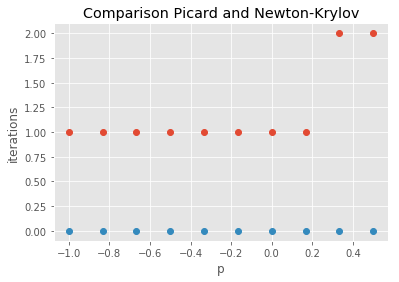

In [156]:
pval = numpy.linspace( -1, 0.5, 10 ) 
iter_old = [] 
iter_new = []
for p in pval:
    _,i = fsolve_newtonkrylov( h, x, y, p, eps, u, rtol=1e-6, verbose=True )
    iter_new.append( i )
    _, _, _, i = solve_nonlinear( 0.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)),verbose=False, p=p, eps=0.1 )
    iter_old.append(i)
pyplot.plot(pval, iter_old, 'o', label='Picard')
pyplot.plot(pval, iter_new, 'o', label='Newton-Krylov')
pyplot.xlabel('p')
pyplot.ylabel('iterations')
pyplot.title('Comparison Picard and Newton-Krylov')

3. Can you directly implement a Newton linearization?  Either do it or explain what is involved. 
How will its nonlinear convergence compare to that of the Newton-Krylov method?


In order to implement a full newton method we also have to differentiate $/kappa$ with respect to u in order to compute the correct full jacobian.